# Stock Portfolio Optimization with Particle Swarm Optimizer
*Author:* **Daniel Carpenter**  
*Final Project - July 2022*   
*Financial Engineering*  

## Overview of Code
1. Inputs for model:
    * Stock tickers from publically traded companies on Yahoo Finance 
    * Date range of Stocks to include in sample (Default last 10 years)
    * Minimum desired return on portfolio
    * Whether to minimize risk or mazimize the Sharpe ratio
    * Some Metaheuristic inputs   
    
2. **Imports Stocks** based on inputs using `from StockPull import *` *(set to top 50 market cap. stocks in U.S.)*
3. Manipulates stock data to get excess returns, variance-covariance matrix, etc. for **Modern Porfolio Theory**
4. Solves for **minimum risk** (or maximum sharpe) porfolio using **Particle Swarm Optimization**
5. Returns optimal allocation of weights to invest into stocks and associated investment weights
6. **Appendix** that compares performance of metaheuristic with changes in parameters


In [1]:
# PACKAGES 
# -----------------------------------------------------------------------------
import pandas   as pd
import numpy    as np
import datetime as dt
import matplotlib.pyplot as plt


In [3]:
# =============================================================================
# INPUT PARAMETERS
# =============================================================================

# Date range for stock & t-bill data pull - default last 10 years
maxDate = dt.datetime.now()                     # Max date to pull from
minDate = maxDate - dt.timedelta(days=10 * 365) # Min date to pull from

# List of stock tickers to pull data from (top 50 market cap stocks companies in US S&P 500)
StockTickers = ['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'TSLA', 'JNJ', 'UNH', 'META', 'V', 'NVDA', 'XOM', 'PG', 'WMT', 'JPM', 'MA', 'LLY', 'HD', 'PFE', 'CVX', 'BAC', 'KO', 'ABBV', 'MRK', 'PEP', 'VZ', 'TMO', 'COST', 'AVGO', 'ABT', 'DHR', 'ORCL', 'MCD', 'ADBE', 'CSCO', 'CMCSA', 'CRM', 'DIS', 'TMUS', 'NKE', 'BMY', 'PM', 'UPS', 'INTC', 'NEE', 'T', 'WFC', 'TXN', 'RTX', 'QCOM']

# Return and investment strategies
totalIterations  = 3000      # Main Stopping criteria = the total number of iterations
evalGoal         = 'risk'    # Minimze 'risk' or maximize 'sharpe'
minDesiredReturn = 0.075     # meet the minimum desired return. E.g. 7.5%
numPorfolios     = 30        # number of portfolios in swarm to simulate
method           = 'local'   # 'local' or 'global' best function name


In [4]:
# Helper Inputs 
# -----------------------------------------------------------------------------

MONTHS_IN_YEAR = 12 # The number of months in a year

# bounds for evaluation Function search space
lowerBound        = 0   # no weight in a stock
upperBound        = 1   # Max weight in stock


## Call Function to Import List of Stock Data
*`StockPull.py` must be in working directory*

In [5]:
# =============================================================================
# Import stocks (monthly)
# =============================================================================

from StockPull import * # to pull in stock data


# Pull in data based on input parameters (Stock tickers, date range)
RawStockData = pullStockData(StockTickers, minDate, maxDate)

# Pivot so that each stock is its own column
RawStockDataPivot = RawStockData.copy().pivot(index='period', columns='stock',  values='adjClose')
RawStockDataPivot.to_csv('RawStockDataPivot.csv')


# =============================================================================
# Import T-Bill (monthly)
# T-Bill Ref: https://finance.yahoo.com/quote/%5EIRX/history/
# =============================================================================

# Get the average risk free rate
T_Bill = pullStockData(['^IRX'], minDate, maxDate)

# Get the annualized average t-bill rate over date range
# Need over date range to get risk adjusted returns (Sharpe Ratio)
riskFreeRate = T_Bill['adjClose'].mean() / 100 # 100%



[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

[******************

### For ease of viewing, below shows the stock pull function 

In [6]:
import inspect

# Get the stock pull function source code
stockPullFunction = inspect.getsource(pullStockData)

# Note the code to import the stock data:
print(stockPullFunction)

def pullStockData(StockTickers, minDate, maxDate, interval='1mo'):
    
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    
    # Can dowload the following:
    # "Stock", "Open", "High", "Low", "Close", "Adj Close", "Volume"
    stockMetrics = ["Adj Close"]
    
    # Create df to hold the stocks pulled
    PulledStocks = pd.DataFrame(columns = stockMetrics)

    count = 0
    outOf = len(StockTickers)
    
    # Pull each stocks
    for stock in StockTickers:  
        
        count += 1 # Keep track
        
        # Get the stock ticker over the date range
        print('\nDownloading', stock, '- Progress:', count, '/', outOf)
        stockTicker = yf.download(stock, start=minDate, end=maxDate, 
                                  interval=interval)
        
        # Force reset to coerce to date
        stockTicker = stockTicker.reset_index()
        
        # Assign the ticker name to the stock
        stockTicker["Stock"] = stock
        
        # Concat

## Use Modern Porfolio Theory

### Calculates:
1. Percent return for each stock
2. Expected Return for each stock
3. Excess Returns for each stock and month
4. Variance-Covariance Matrix

In [7]:
# =============================================================================
# Manipulate stock data
# Create Returns, ExcessReturns, and ExpectedReturns data frames
# Using section 10.2 of Financial Modeling, 4th ed., Benninga
#
# df Percent change pandas: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html
# Group by & mean pandas: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
# Transposing: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html
# Matrix Multiplication: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dot.html
# =============================================================================


# 1. Get the percent return for each stock, for each period
# -- Calculation: Returns = This period return divided by last period minus 1, for each stock
# -----------------------------------------------------------------------------

# Create a data frame for the returns using raw data
Returns = RawStockDataPivot.copy()

# % Return = Percent change from last period to period + 1
# Also, Remove the na for the first periods
Returns = Returns.pct_change().dropna()


# 2. Get the Expected Return for each stock
# -- Calculation: ExpectedReturn = mean(Returns), for each stock
# -----------------------------------------------------------------------------

# Using the Returns data
ExpectedReturns = Returns.copy()

# Group by all periods and get the mean
ExpectedReturns['AllPeriods'] = 'AllPeriods'
ExpectedReturns = ExpectedReturns.groupby('AllPeriods').mean()


# 3. Calculate the Excess Returns for each stock and month
# -- Calculation: ExcessReturns = Returns - ExpectedReturns, for each stock
# -----------------------------------------------------------------------------

ExcessReturns = Returns.copy() - np.array(ExpectedReturns)


# 4. Variance-Covariance Matrix
# -- Calculation: ( t(ExcessReturns) * ExcessReturns ) / ( numPeriods - 1 )
# -----------------------------------------------------------------------------

# Number of periods in sample
numPeriods = len(ExcessReturns.index)

# Covariances between stocks (variance covariance matrix)
VarCov = ExcessReturns.transpose().dot(ExcessReturns) / ( numPeriods - 1 )


## Finance Functions for Optimization
*Functions for evaluating the risk, sharpe ratio, and expected return of a simulated portfolio*


In [8]:
# =============================================================================
# Functions to Evaluate Risk, Expected Return, and Sharpe Ratio
# -- Will be used when optimizing portfolio 
# =============================================================================

# Function to Calculate the ExpectedReturn
# -- Calculation: expectedReturn = MONTH_IN_YEAR * ( Weights * t(ExpectedReturns) )
# -----------------------------------------------------------------------------
def evalExpectedReturn(MONTHS_IN_YEAR, Weights, ExpectedReturns):

    Weights = np.array(Weights)    

    expectedReturn = MONTHS_IN_YEAR * ( Weights.dot( ExpectedReturns.transpose() ) )
    return expectedReturn[0]


# Function to Calculate the Risk
# -- Calculation: risk = sqrt(12) * sqrt( ( Weights * VarCov ) * t(Weights) )
# -----------------------------------------------------------------------------
def evalRisk(MONTHS_IN_YEAR, Weights, VarCov, ExpectedReturns, minDesiredReturn):
    
    # convert to numpy array
    Weights = np.array(Weights)
    
    # IF not the return desired then put a penalty on the portfolio
    # if evalExpectedReturn(MONTHS_IN_YEAR, Weights, ExpectedReturns) < minDesiredReturn:
    #     risk = 9999 # large penalty
        
    # # Else if desired return, then return actual risk
    # else:
    risk = np.sqrt(MONTHS_IN_YEAR) * np.sqrt( ( Weights.dot(VarCov) ).dot( Weights.transpose() ) )
    
    return risk


# Function to Calculate the SharpeRatio
# -- Calculation: (expectedReturn - riskFreeRate) / risk 
# -----------------------------------------------------------------------------
def evalSharpeRatio(expectedReturn, riskFreeRate, risk):
    
    sharpeRatio = ( expectedReturn - riskFreeRate ) / risk 
    return sharpeRatio


## Metaheuristic Support Functions to Optimize Portfolio

In [21]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Use metaheuristics to solve for the optimal portfolio
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# =============================================1================================
# evaluation FUNCTION
# evaluation function to evaluate a real-valued solution x
# note: the feasible space is an n-dimensional hypercube centered at the origin with side length = 2 * 500
# =============================================================================
def evalFunction(Weights, evalGoal='risk'):
    
    # For every portfolio portfolio, calculate the fitness value based on evaluation function
    
    ## Calculate the risk
    risk = evalRisk(MONTHS_IN_YEAR, Weights, VarCov, ExpectedReturns, minDesiredReturn)
    
    ## Calculate the sharpe ratio
    sharpeRatio = evalExpectedReturn(MONTHS_IN_YEAR, Weights, ExpectedReturns)

    fitnessValue = 0 # initialize the output variable

    # Evaluate using the risk (minimize the risk of portfolio)
    if evalGoal == 'risk':
        fitnessValue = risk
    
    # Else use the sharpe ratio (maximize the sharpe ratio of portfolio):
    # Note changed signs because we want to dynamically maximize
    else: 
        fitnessValue = -sharpeRatio

    return fitnessValue

# =============================================================================
# GLOBAL MIN VALUE AND POSITION SEARCH FUNCTION
# Returns the 2 element list (each containing a single value) with the global best portfolio's:
# ---- [0] min value and 
# ---- [1] associate Weights of 
# =============================================================================
def getGlobalBest(FitnessValues, Weights, numPorfolios):
    minValue = np.min(FitnessValues)         # Find the Minimum fitness value of all portfolios
    minIndex = FitnessValues.index(minValue) # Find the index of the Weights for the min. fit. value
    
    minPosition = Weights[minIndex][:] # Now get a copy of the portfolio's Weights with min index
    
    # Returns: the global best portfolio's minimum fitness value and its Weights
    return [minValue, minPosition] 


# =============================================================================
# LOCAL MIN VALUE AND POSITION SEARCH FUNCTION
# Topology: Ring structure with n neighbors  (default 2)
# Returns the 2 element list of lists with the each portfolio's local best within neighborhood
# ---- [0] min value and 
# ---- [1] associate Weights of 
# Can change numStocksInNbrhd to consider more or less in portfolio's neighborhood
# =============================================================================
def getLocalBest(FitnessValues, Weights, numPorfolios,
                  numStocksInNbrhd = 2):  # Number of portfolios to compare to for local best

    lBestFitValue = [] # will hold the best VALUE    of the n surrounding portfolios, for each portfolio
    lBestPosition = [] # will hold the best POSITION of the n surrounding portfolios, for each portfolio
    
    
    # For every portfolio in the portfolio swarm, (starting at n less than index 0)
    for portfolio in range(-numStocksInNbrhd, numPorfolios - numStocksInNbrhd):
        
        # Identify the two neighbors fitness value of this portfolio, 
        # which are the two precedng portfolios
        personalBestNeighbor1 = FitnessValues[portfolio]
        personalBestNeighbor2 = FitnessValues[portfolio + 1]
        
        # Identify the lowest fitness value of this portfolio's the two preciding neighbors
        minNeighValue = min(personalBestNeighbor1, personalBestNeighbor2)
        
        # Store the index of the portfolio
        minNeighIndex = FitnessValues.index(minNeighValue)
        
        # Store the portfolio's best neighbors fitness value and Weights
        lBestFitValue.append(FitnessValues[minNeighIndex])
        lBestPosition.append(Weights[minNeighIndex])
        
    # Returns a list of portfolios and the min of their n best fit. valued neighbors
    return[lBestFitValue, lBestPosition]


# If you needed to index the list just returned for global or local best
VALUE_IDX    = 0
POSITION_IDX = 1


# =============================================================================
# STEP 1 - SWARM INITIALIZATION / EVALUATION
# Randomly initialize a portfolio swarm instance
# Set the partical's best to it's starting Weights
# =============================================================================
def initializeSwarm(numPorfolios, numStocksInPort, functionToGetBest, evalGoal, absoluteMoveLimit):
    
    # In the current time period, Weights[portfolio] and Velocity[portfolio] of each portfolio i, 
    Weights  = [] # to hold the portfolio weights
    Velocity = [] # to hold the portfolio velocities

    # Lists containing info related to each portfolio in portfolio swarm
    pCurrFitValue = []  # X[portfolio] The current Weights of portfolio i
    
    # For each portfolio and stock, randomly initialize the...
    for portfolio in range(numPorfolios):
        # for stock in range(numStocksInPort):
            
        # Create a random feasible solution
        randomValues = np.random.rand(numStocksInPort)
        randomWeights = randomValues / sum(randomValues)
        
        # Ensure that it is an initial feasible solution meeting return contraint
        while evalExpectedReturn(MONTHS_IN_YEAR, randomWeights, ExpectedReturns) < minDesiredReturn:
            randomValues = np.random.rand(numStocksInPort)
            randomWeights = randomValues / sum(randomValues)
            
         
        # Position: give random solution of weights summing to 1
        Weights.append(randomWeights)
        
        # Velocity: give random value between lower and upper bound
        Velocity.append(np.random.rand(numStocksInPort) * absoluteMoveLimit)
    
        # 1.1 - Evaluate fitness value
        pCurrFitValue.append(np.sum( evalFunction(Weights[:], evalGoal) ))  # evaluate the current Weights's fitness value
        
    # 1.2 - Log the individual and global bests
    pBestPosition = Weights[:]       # initialize pBestPosition to the starting Weights
    pBestFitValue = pCurrFitValue[:]  # initialize pBestPosition to the starting Weights's value


    # 1.3 - Log the Global or local best (depends on chosen method) fitness value and Weights
    glBestFitValue, glBestPosition = functionToGetBest(pBestFitValue[:], pBestPosition[:], numPorfolios) 
    
    return [Weights, Velocity, pCurrFitValue, 
            pBestPosition, pBestFitValue, 
            glBestFitValue, glBestPosition]


# =============================================================================
# UPDATE VELOCITY AND POSITION 
# =============================================================================
def updateVelocityAndWeights(intertiaWeight, Velocity, Weights, phi1, phi2, pBestPosition, glBestPosition,
                              numPorfolios, numStocksInPort, absoluteMoveLimit):
# Velocity --------------------------------------------------------------------
    
    ## random weights of r for random Velocity adjustment
    r1, r2 = np.random.rand(), np.random.rand() 
    
    ## Calculations of updating Velocity, separated by 
    ## intertia + cognitive + social (for simplicity)
    vInertia   = np.multiply(intertiaWeight, Velocity[:])                          # Interia   component of updated Velocity
    vCognitive = np.multiply(phi1*r1, np.subtract( pBestPosition[:], Weights[:])) # Cognitive component of ""
    vSocial    = np.multiply(phi2*r2, np.subtract(glBestPosition[:], Weights[:])) # Social    component of ""
    
    ## Update the new Velocity to the summation of intertia, cognitive, and social
    newVelocity =  vInertia[:] + vCognitive[:] + vSocial[:]
    
    ## Limit the Velocity between the upper and lower bound limits
    for portfolio in range(numPorfolios):
        for stock in range(numStocksInPort):
        
            # If the new Velocity of portfolio i is > the ub move limit, then reduce to the limit
            if newVelocity[portfolio][stock] > absoluteMoveLimit:
                newVelocity[portfolio][stock] = absoluteMoveLimit
                
            # If the new Velocity of portfolio i is < the limit, then increase to the limit
            if newVelocity[portfolio][stock] < -absoluteMoveLimit:
                newVelocity[portfolio][stock] = -absoluteMoveLimit
        
    # Position ----------------------------------------------------------------
    
    ## Update new Weights based on the updated Velocity
    newWeights = Weights[:] + newVelocity[:] 
    
    
    ## Make sure that the Weights is within the bounds -----------------------
    
    # For each portfolio and stock
    for portfolio in range(numPorfolios):
        for stock in range(numStocksInPort):
            
            # Push the new Weights to lower bound if lower
            if newWeights[portfolio][stock] < lowerBound:
                newWeights[portfolio][stock] = lowerBound
            
            # Push the new Weights to upper bound if higher
            if newWeights[portfolio][stock] > upperBound:
                newWeights[portfolio][stock] = upperBound

        
    for portfolio in range(numPorfolios):
            
        # Balance the weights to equal 1.
        # Be sure to keep move limit close to 1
        newWeights[portfolio] = np.array(newWeights[portfolio]) / sum(newWeights[portfolio])
        
    
    # Convert Weights and Velocity back to list ------------------------------
    newWeights  = newWeights.tolist()
    newVelocity = newVelocity.tolist()
    
    return [newWeights, newVelocity]


# =============================================================================
# Compare current Weights fitness value to the current best (for each portfolio)
# =============================================================================
def calculatePortfolioBests(Weights, numPorfolios, numStocksInPort,
                           pCurrFitValue, pBestPosition, pBestFitValue, evalGoal):
    # Calculate the fitness of the new Weights
    for portfolio in range(numPorfolios):
        # for stock in range(numStocksInPort):
            
        # Get the current fitness value of the new Weights
        pCurrFitValue[portfolio] = evalFunction(Weights[:][portfolio], evalGoal)
        
        # Compare the current Weights' value to their person best
        if pCurrFitValue[portfolio] < pBestFitValue[portfolio]:
        
            # If better, then set the best VALUE to the current value (as a copy [:])
            pBestFitValue[portfolio] = pCurrFitValue[:][portfolio]
            
            # If better, then set the best POSITION to the current Weights  (as a copy [:])
            pBestPosition[portfolio] = Weights[:][portfolio]
    
    return [pCurrFitValue, pBestPosition, pBestFitValue]


# =============================================================================
# DISPLAY GLOBAL BEST AND DIMENSIONS FUNCTION
# Function for displaying the global best and its dimensions
# =============================================================================
def displayGlobalBest(glBestFitValue, glBestPosition, numStocksInPort, 
                      printDims, StockTickers, expectedReturn,
                      riskFreeRate, evalGoal, 
                      numPeriods=numPeriods,
                      MONTHS_IN_YEAR=MONTHS_IN_YEAR):
    
    # The sharpe ratio
    sharpeRatio = evalSharpeRatio(expectedReturn, riskFreeRate, glBestFitValue)

    # Total % return over the entire period
    monthsInSample = numPeriods/MONTHS_IN_YEAR # since on monthly basis
    returnOverPeriod = (1 + expectedReturn) ** monthsInSample
    
    # Flip signs if maximizing sharpe
    if evalGoal != 'risk':
        glBestFitValue = -glBestFitValue
        sharpeRatio    = -sharpeRatio
        
    # Print the global optima
    print('\n```')
    print('Key Summary Statistics -----------------')
    print(  'Global Best Annualized Risk:\t ' + str(round(100 * glBestFitValue, 1))  + '%')
    print(  'Annualized Expected Return:\t ' + str(round(100 * expectedReturn, 1))  + '%')
    print(  'Sharpe Ratio:\t\t\t% 0.2f' % sharpeRatio)
    print(  'Expected Return over', str(round(monthsInSample, 1) ), 'Years:  ' 
          + str(round(100 * returnOverPeriod, 1))  + '%')
    
    
    # Print each stock (if toggled)
    if printDims:
        print('\nGlobal best weights in each stock (Only includes stocks to invest in):')
        print('```')
        
        # Print the Weights of each stock in markdown table format
        print('| Ticker | Opt. Weight |', sep ='')
        print('|--------|-------------|')
        for stock in range(numStocksInPort):
            if glBestPosition[stock] > 0.001:
                print('|' + str(StockTickers[stock]).rjust(7, ' '), 
                      '|' + '{:.1f}'.format(100 * round(glBestPosition[stock], 3) ).rjust(11, ' ') + '% |'
                      )
    
                
# =============================================================================
# Plot the optimal weights and prices performance
# =============================================================================
def plotOptimalPerformance(RawStockDataPivot, OptimalWeights):
    
    # Calculate the weighted prices using adj close prices and optimal weights
    OptimizedPrices = RawStockDataPivot.copy().dropna().dot(OptimalWeights.copy())
    
    # Create a plot
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    # Plot the weighted prices
    plt.plot(OptimizedPrices)
    
    # Labels
    ax.set_title("Wt.'d Monthly Adj. Close Price of Optimal Portfolio")
    ax.set_xlabel('Month of Year (Year Only Shown for Simplicity)')
    ax.set_ylabel('Weighted Adj. Close Price (USD)')
    

## Driver Function to Optimize Portfolio Weights

In [22]:

# =============================================================================
# SWARM OPTIMIZATION FUNCTION
# Parameters:
# ---- evalGoal:        Minimize 'risk' or maximize 'sharpe' ratio
# ---- numPorfolios:    The number of portfolios within the portfolio swarm
# ---- intertiaWeight:  The weight assigned to the intertia component of the Velocity eq.
# ---- phi1:            Cognitive weight of the Velocity equation. Note phi1 + phi2 <= 4
# ---- phi2:            Social    weight of the Velocity equation. Note phi1 + phi2 <= 4
# ---- totalIterations: The total number of iterations before stopping (Stopping criterion)
# ---- method:          Can use 'local' or 'global' best methods. 
# ----                  'local' uses Ring Structure with 2 neighbors by default 
# ----                  If using 2D and 'global' best method, will export CSV.
# ----                  Reason for exporting is to read in data to R for plotting iterations
# ---- printDims:       Print the dimensions' value or not
# ---- StockTickers:    Tickers of the stocks pulled
# ---- RawStockDataPivot: Raw stock adj.close prices pivoted for showing performance over duration
# =============================================================================

def optimizePortfolioPSO( # -------------------- Defaults --------------------
    evalGoal        = 'risk',   # Minimize 'risk' or maximize 'sharpe'
    minDesiredReturn= minDesiredReturn,# THe minimum desired return
    numPorfolios    = 5,        # number of portfolios in swar
    phi1            = 2,        # Cognitive weight
    phi2            = 2,        # Social weight
    intertiaWeight  = 0.1,      # Constant Inertia weighting value,
    absoluteMoveLimit = 0.1,    # max of 10 pp change in weight
    totalIterations = 10000,    # Stopping criteria = the total number of iterations
    method          = 'local',  # 'local' or 'global' best function name
    printDims       = True,     # Print the stock's value or not,
    StockTickers    = StockTickers, # Tickers of the stocks pulled,
    RawStockDataPivot = RawStockDataPivot # The raw stock data for plotting weighted performance
    ):
    
    numStocksInPort = len(StockTickers) # number of dimensions of problem

    
    # Initialize to global best function by default
    functionToGetBest = getGlobalBest
    
    # If not using the global best, then switch to the local best method
    if method != 'global':
        functionToGetBest = getLocalBest    
    
    
    # -----------------------------------------------------------------------------
    # INITIALIZE POSITION AND VELOCITY, and INITIAL BESTS
    # the portfolio swarm will be represented as a list of Weights, velocities, values, 
    # pBestPosition, and pBestPosition values
    # Note: Weights[0] and Velocity[0] provides the Weights and Velocity of portfolio 0; 
    # Weights[1] and Velocity[1] provides the Weights and Velocity of portfolio 1; and so on.
    # -----------------------------------------------------------------------------
    
    
    # Step 1: Initialize portfolio swarm and get the portfolios' and global best (and current Weights)
    Weights, Velocity, pCurrFitValue, pBestPosition, pBestFitValue, glBestFitValue, glBestPosition = initializeSwarm(numPorfolios, numStocksInPort, 
                                                                                                                     functionToGetBest, evalGoal, absoluteMoveLimit)
    
    # Create empty lists for holding the portfolio swarm iterations
    positionIterations      = [] # Each portfolio's Velocity
    velocityIterations      = [] # Each portfolio's Weights
    gBestPositionIterations = [] # The current Global Best Position
    
    
    # -----------------------------------------------------------------------------
    # Main Loop 
    # -----------------------------------------------------------------------------
    
    iteration = 0
    
    # While meeting total iteration and min desired return requirements
    while (iteration < totalIterations) and ( ( evalExpectedReturn(MONTHS_IN_YEAR, glBestPosition[:], ExpectedReturns) < minDesiredReturn) or ( evalExpectedReturn(MONTHS_IN_YEAR, glBestPosition[:], ExpectedReturns) > minDesiredReturn * 1.01) ): 
        
        # Step 0: Keep track of each iterations/stock for Velocity, Weights, and current global best
        velocityIterations.append(Velocity)           
        positionIterations.append(Weights)           
        gBestPositionIterations.append(glBestPosition) 
        
        # Step 2: Update the Velocity and Weights
        Weights, Velocity = updateVelocityAndWeights(intertiaWeight, Velocity, Weights, 
                                                     phi1, phi2, pBestPosition, glBestPosition,
                                                     numPorfolios, numStocksInPort,
                                                     absoluteMoveLimit)
        
        # Step 3: Recalculate the portfolio and global bests
        pCurrFitValue, pBestPosition, pBestFitValue = calculatePortfolioBests(Weights, 
                                                                              numPorfolios, numStocksInPort,
                                                                              pCurrFitValue, 
                                                                              pBestPosition, 
                                                                              pBestFitValue, 
                                                                              evalGoal)
                
        # Step 4: Get the Global or local best (depends on chosen method) fitness value and Weights
        glBestFitValue, glBestPosition = functionToGetBest(pBestFitValue[:], pBestPosition[:], numPorfolios) 
        
        iteration += 1 # increment iterator

    
    # -----------------------------------------------------------------------------
    # Global Best
    # -----------------------------------------------------------------------------
    
    # Finally, if using the local best method, get the absolute best from the local bests
    if method == 'local':
        gBestFitValue, gBestPosition = getGlobalBest(glBestFitValue, glBestPosition, numPorfolios)
        expectedReturn = evalExpectedReturn(MONTHS_IN_YEAR, gBestPosition, ExpectedReturns)
    
    else: # if not local best, then change the gl best is the global best
        gBestFitValue, gBestPosition = glBestFitValue, glBestPosition
        expectedReturn = evalExpectedReturn(MONTHS_IN_YEAR, gBestPosition, ExpectedReturns)
        
    # -----------------------------------------------------------------------------
    # Print and Export
    # -----------------------------------------------------------------------------
    
    # Print the global (or local best) and each dimensions' Weights
    displayGlobalBest(gBestFitValue, gBestPosition, numStocksInPort, printDims, 
                      StockTickers, expectedReturn, riskFreeRate, evalGoal)
    
    # Show the weighted price perfgormance of the oprtimal portfolio weights
    plotOptimalPerformance(RawStockDataPivot, gBestPosition.copy())
    
    return [gBestPosition, gBestFitValue] # return the best weights and risk


## Solve for Optimal Portfolio 
* *Uses inputs at the top of the file to return the key statistics and the optimal weights of stocks to invest in.*  
* *Note that only shows the weights if greater than 0.1%*  


```
Key Summary Statistics -----------------
Global Best Annualized Risk:	 10.0%
Annualized Expected Return:	 15.0%
Sharpe Ratio:			 1.44
Expected Return over 9.4 Years:  373.9%

Global best weights in each stock (Only includes stocks to invest in):
```
| Ticker | Opt. Weight |
|--------|-------------|
|      V |        0.3% |
|   NVDA |        0.7% |
|     PG |        0.3% |
|     MA |        3.4% |
|    PFE |        3.7% |
|     KO |        0.4% |
|   ABBV |       11.6% |
|    PEP |       12.2% |
|     VZ |        0.5% |
|   COST |        0.6% |
|   AVGO |       11.5% |
|    MCD |        0.1% |
|   CSCO |        9.7% |
|    DIS |        1.0% |
|   TMUS |       13.5% |
|    UPS |        5.0% |
|   INTC |        6.6% |
|    WFC |        9.0% |
|    RTX |        9.5% |


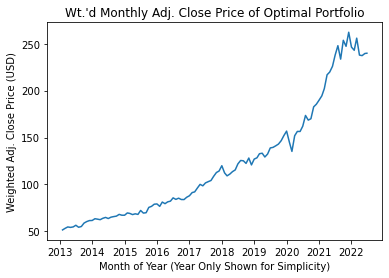

In [26]:
# Call the function based on the imputs at the top
gBestSolution = optimizePortfolioPSO(
                    evalGoal        = evalGoal,        # Minimize 'risk' or maximize 'sharpe'
                    minDesiredReturn= minDesiredReturn,# The minimum desired return
                    numPorfolios    = numPorfolios,    # number of portfolios in swarm to simulate
                    totalIterations = totalIterations, # Main Stopping criteria = the total number of iterations
                    method          = method,          # 'local' or 'global' best function name
                    StockTickers    = StockTickers     # The stock tickers
                    )

---

# Appendix - Testing Changes in Parameters
* Goal is to see how changing parameters affect objectives
* Note that each change does not accumulate. Each are in isolation and comparison of the original inputs at the top. This is for a more direct comparison of performance.

## *(Test 1)*: More Iterations and Less Simulated Porfolios Performs Worse
*See risk increased and not found global optima*


```
Key Summary Statistics -----------------
Global Best Annualized Risk:	 12.0%
Annualized Expected Return:	 18.1%
Sharpe Ratio:			 1.45
Expected Return over 9.4 Years:  477.7%

Global best weights in each stock (Only includes stocks to invest in):
```
| Ticker | Opt. Weight |
|--------|-------------|
|   AAPL |        4.3% |
|   MSFT |        1.4% |
|   GOOG |        5.3% |
|   AMZN |        0.5% |
|   TSLA |        0.4% |
|   META |        0.4% |
|      V |        2.9% |
|   NVDA |        1.7% |
|    XOM |        1.0% |
|    WMT |        2.4% |
|    LLY |        1.1% |
|    PFE |        0.4% |
|    CVX |       10.9% |
|    BAC |        3.8% |
|    PEP |        6.2% |
|     VZ |        1.7% |
|    TMO |        2.7% |
|   COST |        1.4% |
|    ABT |        4.9% |
|    DHR |        0.6% |
|    MCD |        5.9% |
|   ADBE |        1.6% |
|   CSCO |        3.1% |
|  CMCSA |        0.6% |
|    CRM |        1.3% |
|   TMUS |        1.5% |
|    NKE |        4.9% |
|    BMY |        5.

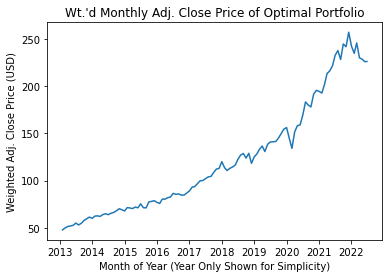

In [27]:
# Increase from 3000 to 10000
totalIterations  = 10000     # Main Stopping criteria = the total number of iterations

# Decrease from 30 to 10
numPorfolios     = 10        # number of portfolios in swarm to simulate

# Run optimization again
gBestSolution = optimizePortfolioPSO(
                    evalGoal        = evalGoal,        # Minimize 'risk' or maximize 'sharpe'
                    minDesiredReturn= minDesiredReturn,# The minimum desired return
                    numPorfolios    = numPorfolios,    # number of portfolios in swarm to simulate
                    totalIterations = totalIterations, # Main Stopping criteria = the total number of iterations
                    method          = method,          # 'local' or 'global' best function name
                    StockTickers    = StockTickers     # The stock tickers
                    )

## *(Test 2)*: Maximizing Sharpe Ratio Tends to Invest in only 1 Stock
* Not recomended to maximize the Sharpe ratio with this metaheuristic
* Note that iterations and number of simulated portfolios reset to original values



```
Key Summary Statistics -----------------
Global Best Annualized Risk:	 68.4%
Annualized Expected Return:	 68.4%
Sharpe Ratio:			 0.99
Expected Return over 9.4 Years:  13544.6%

Global best weights in each stock (Only includes stocks to invest in):
```
| Ticker | Opt. Weight |
|--------|-------------|
|     PM |      100.0% |


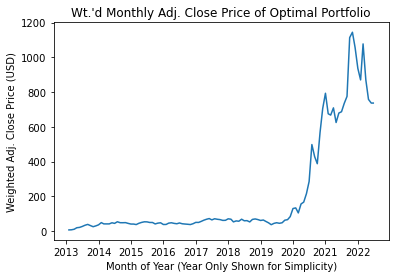

In [29]:
# Change the evaluation to maximize Sharpe ratio
evalGoal         = 'sharpe'    # Minimze 'risk' or maximize 'sharpe'

# Reset recent change of iterations and the number of portfolios
totalIterations  = 3000      # Main Stopping criteria = the total number of iterations
numPorfolios     = 30        # number of portfolios in swarm to simulate

# Run optimization again
gBestSolution = optimizePortfolioPSO(
                    evalGoal        = evalGoal,        # Minimize 'risk' or maximize 'sharpe'
                    minDesiredReturn= minDesiredReturn,# The minimum desired return
                    numPorfolios    = numPorfolios,    # number of portfolios in swarm to simulate
                    totalIterations = totalIterations, # Main Stopping criteria = the total number of iterations
                    method          = method,          # 'local' or 'global' best function name
                    StockTickers    = StockTickers     # The stock tickers
                    )

## *(Test 3)*: Global Best Neighborhood Operator Performs worse than Local Best

* Notice more stocks invested in. Potentially due to principle of diversification knowing all possible portfolio's
* *See risk increased and not found global optima*


```
Key Summary Statistics -----------------
Global Best Annualized Risk:	 12.7%
Annualized Expected Return:	 19.0%
Sharpe Ratio:			 1.45
Expected Return over 9.4 Years:  513.2%

Global best weights in each stock (Only includes stocks to invest in):
```
| Ticker | Opt. Weight |
|--------|-------------|
|   AAPL |        3.3% |
|   GOOG |        2.2% |
|  GOOGL |        1.1% |
|   AMZN |        1.5% |
|   TSLA |        0.9% |
|    JNJ |        0.5% |
|    UNH |        2.1% |
|   META |        0.2% |
|      V |        3.8% |
|   NVDA |        0.7% |
|    XOM |        1.4% |
|     PG |        3.7% |
|    WMT |        3.2% |
|    JPM |        1.9% |
|     MA |        3.9% |
|    LLY |        3.9% |
|     HD |        2.7% |
|    PFE |        4.1% |
|    CVX |        0.3% |
|    BAC |        1.6% |
|     KO |        3.8% |
|   ABBV |        2.8% |
|    MRK |        0.2% |
|    PEP |        4.3% |
|     VZ |        1.0% |
|    TMO |        3.4% |
|   COST |        0.9% |
|   AVGO |        3.

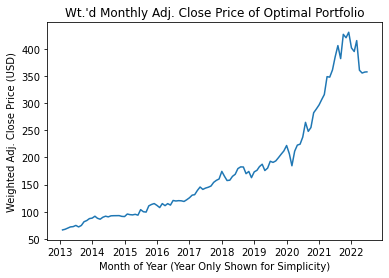

In [30]:
# Change the the neighborhood operator to global best (from local best)
method = 'global'

# Reset recent change of sharpe ratio
evalGoal = 'risk'    # Minimize 'risk' or maximize 'sharpe'

# Run optimization again
gBestSolution = optimizePortfolioPSO(
                    evalGoal        = evalGoal,        # Minimize 'risk' or maximize 'sharpe'
                    minDesiredReturn= minDesiredReturn,# The minimum desired return
                    numPorfolios    = numPorfolios,    # number of portfolios in swarm to simulate
                    totalIterations = totalIterations, # Main Stopping criteria = the total number of iterations
                    method          = method,          # 'local' or 'global' best function name
                    StockTickers    = StockTickers     # The stock tickers
                    )

## *(Test 4)*: More Iterations and More Simulated Portfolios Performs Marginally Better
* Risk decreased from 10.0% to 9.5%
* Sharpe Ratio increased from 1.44 to 1.45


```
Key Summary Statistics -----------------
Global Best Annualized Risk:	 9.5%
Annualized Expected Return:	 14.4%
Sharpe Ratio:			 1.45
Expected Return over 9.4 Years:  355.4%

Global best weights in each stock (Only includes stocks to invest in):
```
| Ticker | Opt. Weight |
|--------|-------------|
|    UNH |        4.8% |
|   NVDA |        2.4% |
|     MA |        0.6% |
|    PFE |        3.6% |
|    BAC |        0.6% |
|   ABBV |       10.9% |
|    PEP |        8.8% |
|    TMO |        5.5% |
|   AVGO |        8.9% |
|   ORCL |        9.8% |
|   CSCO |       17.4% |
|   TMUS |        6.5% |
|    BMY |        6.6% |
|    WFC |        7.3% |
|    RTX |        6.1% |


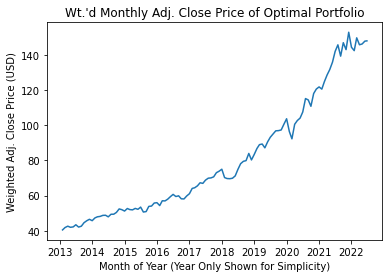

In [31]:
# Increase from 3000 to 10000
totalIterations  = 10000     # Main Stopping criteria = the total number of iterations

# Increase from 30 to 100
numPorfolios     = 100        # number of portfolios in swarm to simulate

# Reset recent change of neighborhood operator back to local best
method = 'local'

# Run optimization again
gBestSolution = optimizePortfolioPSO(
                    evalGoal        = evalGoal,        # Minimize 'risk' or maximize 'sharpe'
                    minDesiredReturn= minDesiredReturn,# The minimum desired return
                    numPorfolios    = numPorfolios,    # number of portfolios in swarm to simulate
                    totalIterations = totalIterations, # Main Stopping criteria = the total number of iterations
                    method          = method,          # 'local' or 'global' best function name
                    StockTickers    = StockTickers     # The stock tickers
                    )

## *(Test 5)*: More Iterations and Even More Simulated Portfolios Performs Marginally Better
* Risk decreased from 10.0% to 9.5%
* Sharpe Ratio decreased from 1.44 to 1.46


```
Key Summary Statistics -----------------
Global Best Annualized Risk:	 9.5%
Annualized Expected Return:	 14.5%
Sharpe Ratio:			 1.46
Expected Return over 9.4 Years:  357.8%

Global best weights in each stock (Only includes stocks to invest in):
```
| Ticker | Opt. Weight |
|--------|-------------|
|    UNH |        4.3% |
|   NVDA |        2.5% |
|     MA |        0.4% |
|    PFE |        3.4% |
|    BAC |        2.0% |
|   ABBV |       11.0% |
|    PEP |        8.1% |
|    TMO |        6.0% |
|   AVGO |        9.2% |
|   ORCL |        9.1% |
|   CSCO |       17.5% |
|   TMUS |        6.7% |
|    BMY |        6.7% |
|    WFC |        6.7% |
|    RTX |        6.3% |


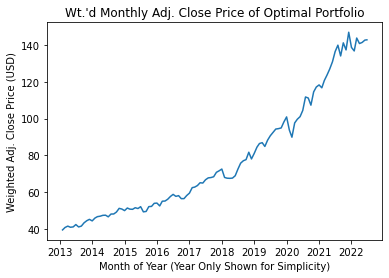

In [32]:
# Increase from 3000 to 10000
totalIterations  = 10000     # Main Stopping criteria = the total number of iterations

# Increase from 30 to 200
numPorfolios     = 200        # number of portfolios in swarm to simulate

gBestSolution = optimizePortfolioPSO(
                    evalGoal        = evalGoal,        # Minimize 'risk' or maximize 'sharpe'
                    minDesiredReturn= minDesiredReturn,# The minimum desired return
                    numPorfolios    = numPorfolios,    # number of portfolios in swarm to simulate
                    totalIterations = totalIterations, # Main Stopping criteria = the total number of iterations
                    method          = method,          # 'local' or 'global' best function name
                    StockTickers    = StockTickers     # The stock tickers
                    )